In [1]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch.nn as nn
import torch_geometric.nn as geom_nn
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

In [2]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))


def MLP_scaling(data,train_indices):
    
    train_data = [ data[train_indices[i]] for i in range(len(train_indices)) ]
    test_indices = np.setdiff1d( np.arange(len(data)) , train_indices  )
    test_data = [ data[test_indices[i]] for i in range(len(test_indices)) ]

    ### Extarcting train data points and flattening (Train) ###
    
    flattened_train_data = list()
    for i in range(len(train_data)):

        flattened_train_data.append(train_data[i].x.flatten())        
    flattened_train_data = torch.stack(flattened_train_data)

    ### Extarcting train data points and flattening (Test) ###
    flattened_test_data = list()
    for i in range(len(test_data)):

        flattened_test_data.append(test_data[i].x.flatten())        
    flattened_test_data = torch.stack(flattened_test_data)

    #######
    ### Data Scaling (Train) ###
    scaler = MinMaxScaler()
    scaler.fit(flattened_train_data)
    scaled_data = scaler.transform(flattened_train_data)

    train_graphs = list()
    
    for i in range(len(scaled_data)):
        train_graphs.append( scaled_data[i].reshape(16,6) )

    ### Data Scaling (Test) ###
    scaled_data = scaler.transform(flattened_test_data)

    test_graphs = list()
    for i in range(len(scaled_data)):
        test_graphs.append( scaled_data[i].reshape(16,6) )
        
    #######

    ### Output Scaling ###
    ### Getting min and max values ###
    max_vals = np.max( np.stack( [train_data[i].y.max() for i in range(len(train_data))] ),axis=0)
    min_vals = np.min( np.stack( [train_data[i].y.min() for i in range(len(train_data))] ),axis=0)

    ### Performing the scaling ###
    train_data_output = [ (train_data[i].y - min_vals)/(max_vals - min_vals) for i in range(len(train_data))] 
    test_data_output = [ (test_data[i].y - min_vals)/(max_vals - min_vals) for i in range(len(test_data))]

    ########

    ### Combine x and y edge indices from the train and test dataset to form a pygnn Data variable ###
    train_combined = list()
    test_combined = list()
    
    for i in range(len(train_graphs)):

        x = torch.tensor(train_graphs[i]).clone()
        edge_index = ( train_data[i].edge_index ).clone()
        y = (train_data_output[i]).clone()
        train_combined.append(Data(x=x , edge_index=edge_index , y=y))

    for i in range(len(test_graphs)):

        x = torch.tensor(test_graphs[i]).clone()
        edge_index = ( test_data[i].edge_index ).clone()
        y = (test_data_output[i]).clone()
        test_combined.append(Data(x=x , edge_index=edge_index , y=y))
        

    return train_combined,test_combined



def add_const_parameter(data,const_param):

    ### Given a numpy array of size m*n , it will return a numpy array of size m*(n+1), where
    ### the last column has all elements as const_param ###

    add_column = np.ones(len(data))*const_param
    
    return np.hstack((data, add_column[:,None]))

def add_const_parameter_to_pandas_list(pandas_list, column_name, const_param):
    """
    Given a list of pandas DataFrames, add a constant parameter to the specified column in each DataFrame.
    """
    result = copy.deepcopy(pandas_list)
    
    for i in range(len(result)):
        result[i][column_name] = np.ones(len(result[i])) * const_param
    
    return result

def merge_columns_to_pandas_list(pandas_list,variable_list,master_dataframe):

    """ given a list of pandas dataframe with the x,y,z locations and re and phi ,this function will
        merge each pandas dataframe from the list with the master dataframe with all the columns  
    """

    joined = copy.deepcopy(pandas_list)

    for i in range(len(joined)):
        print("Particle number : ",str(i+1))
        
        temp = copy.deepcopy(joined[i])
        # print("Unjoined" , temp)
        add = pd.merge(temp,master_dataframe,how="inner",on=['x','Re'],sort=False)[variable_list]
        joined[i] = pd.concat([temp,add], axis=1)
        # print("Joined" , joined[i])
        clear_output(wait=True)
        
    return joined


def mirror_edge_index(edge_index):

    first_row = edge_index[0:1, :]
    second_row = edge_index[1:, :]
    output_tensor = np.concatenate((second_row, first_row), axis=0)
    
    return np.concatenate((edge_index,output_tensor),axis=1)


def weighted_averaging(data):
    
    idx = np.where(data[0][:,4]==0)[0]
    deg_1 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==1)[0]
    deg_2 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==2)[0]
    deg_3 = data[0][idx,1:4].sum()

    return deg_1 + 0.5*deg_2 + 0.25*deg_3 

### Validation ###
# print(all_dat[0].edge_index[:,0:5])
# test = mirror_edge_index(all_dat[0].edge_index[:,0:5].detach().cpu().numpy())
# print(test)

In [3]:
### Reading Raw Data ###
df = pd.read_csv('AR2p5_all_particle_drag.dat.csv', header=0)
df = df.rename(columns={'Center_x': 'x', 'Center_y': 'y', 'Center_z': 'z'})
# all_tags = np.load("ze_tags_2p5.npy")

### Read all center data ###
center_10 = pd.DataFrame(np.loadtxt("center_phi_10.dat"))
center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
center_10_dev = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

center_20 = pd.DataFrame(np.loadtxt("center_phi_20.dat"))
center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
center_20_dev = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

center_30 = pd.DataFrame(np.loadtxt("center_phi_30.dat"))
center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
center_30_dev = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

### Defining all particles ###
center_shifted_10 = particle_shift(center_10,shift=10)[['x','y','z']]
center_shifted_20 = particle_shift(center_20,shift=10)[['x','y','z']]
center_shifted_30 = particle_shift(center_30,shift=10)[['x','y','z']]


In [19]:
### Generate Dataset for Sf=0.1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_10.copy()
dev_particles = center_10_dev.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = [pd.DataFrame(all_particles.iloc[idx[i]]) for i in range(len(idx))]

### Adding Column for solid fraction ###
input_dat = add_const_parameter_to_pandas_list(input_dat,'phi',10)
input_dat = [input_dat[i].reset_index(drop=True) for i in range(len(input_dat))]

### Adding 4 Reynolds Numbers and stacking them ###
temp_re10 = add_const_parameter_to_pandas_list(input_dat,'Re',10).copy()
temp_re50 = add_const_parameter_to_pandas_list(input_dat,'Re',50).copy()
temp_re100 = add_const_parameter_to_pandas_list(input_dat,'Re',100).copy()
temp_re200 = add_const_parameter_to_pandas_list(input_dat,'Re',200).copy()

# ### Joining all Reynolds numbers ###
input_dat = temp_re10 + temp_re50 + temp_re100 + temp_re200
input_dat_sf10 = merge_columns_to_pandas_list(input_dat,["Inclination_angle","Drag_local"],df)

Particle number :  828


In [20]:
# ### Generate Dataset for Sf=0.2 ###
# ### Generating the n nearest neighbors ###
# all_particles = center_shifted_20.copy()
# dev_particles = center_20_dev.copy()

# tree = cKDTree(all_particles.values)
# idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
# input_dat = [pd.DataFrame(all_particles.iloc[idx[i]]) for i in range(len(idx))]

# ### Adding Column for solid fraction ###
# input_dat = add_const_parameter_to_pandas_list(input_dat,'phi',20)
# input_dat = [input_dat[i].reset_index(drop=True) for i in range(len(input_dat))]

# ### Adding 4 Reynolds Numbers and stacking them ###
# temp_re10 = add_const_parameter_to_pandas_list(input_dat,'Re',10).copy()
# temp_re50 = add_const_parameter_to_pandas_list(input_dat,'Re',50).copy()
# temp_re100 = add_const_parameter_to_pandas_list(input_dat,'Re',100).copy()
# temp_re200 = add_const_parameter_to_pandas_list(input_dat,'Re',200).copy()

# ### Joining all Reynolds numbers ###
# input_dat = temp_re10 + temp_re50 + temp_re100 + temp_re200
# input_dat_sf20 = merge_columns_to_pandas_list(input_dat,["Inclination_angle","Drag_local"],df)

In [21]:
# ### Generate Dataset for Sf=0.3 ###
# ### Generating the n nearest neighbors ###
# all_particles = center_shifted_30.copy()
# dev_particles = center_30_dev.copy()

# tree = cKDTree(all_particles.values)
# idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
# input_dat = [pd.DataFrame(all_particles.iloc[idx[i]]) for i in range(len(idx))]

# ### Adding Column for solid fraction ###
# input_dat = add_const_parameter_to_pandas_list(input_dat,'phi',30)
# input_dat = [input_dat[i].reset_index(drop=True) for i in range(len(input_dat))]

# ### Adding 4 Reynolds Numbers and stacking them ###
# temp_re10 = add_const_parameter_to_pandas_list(input_dat,'Re',10).copy()
# temp_re50 = add_const_parameter_to_pandas_list(input_dat,'Re',50).copy()
# temp_re100 = add_const_parameter_to_pandas_list(input_dat,'Re',100).copy()
# temp_re200 = add_const_parameter_to_pandas_list(input_dat,'Re',200).copy()

# ### Joining all Reynolds numbers ###
# input_dat = temp_re10 + temp_re50 + temp_re100 + temp_re200
# input_dat_sf30 = merge_columns_to_pandas_list(input_dat,["Inclination_angle","Drag_local"],df)

In [22]:
### Combining all the datasets from different solid fractions ###
# all_data_pd = input_dat_sf10 + input_dat_sf20 + input_dat_sf30

In [139]:
### Load Data ###
all_data_pd_scaled = np.load("quick_load/first_40/all_data_gnn.npy")
train_indices = np.load("quick_load/first_40/train_indices.npy")
test_indices = np.load("quick_load/first_40/test_indices.npy")
train_inputs_global = torch.tensor(np.load("quick_load/first_40/train_inputs_global.npy"))
test_inputs_global = torch.tensor(np.load("quick_load/first_40/test_inputs_global.npy"))

### Tags and train/test indices ###
all_tags = np.load("quick_load/all_tags.npy")
train_indices = np.load("quick_load/first_40/train_indices.npy")
test_indices = np.load("quick_load/first_40/test_indices.npy")

### Preparing GNN data ###
all_data_graph_struct = list()

edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                           ])

for i in range(len(all_data_pd_scaled)):

    ### setting inputs ###
    x = torch.tensor(all_data_pd_scaled[i][0:64].reshape(16,4)).float().clone().detach()
    
    ### adding drag force as y ###
    y = torch.tensor(all_data_pd_scaled[i][-1][None,None]).float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    all_data_graph_struct.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y.clone().detach()))

train_combined = [all_data_graph_struct[train_indices[i]] for i in range(len(train_indices))] 
test_combined = [all_data_graph_struct[test_indices[i]] for i in range(len(test_indices))]

In [138]:
from itertools import combinations

# Define the range
values_range = range(16)  # Range from 0 to 15

# Find all combinations of 3 values without repetition
combinations_list = np.stack(list(combinations(values_range, 3)))

indx = np.where( np.stack([0 in combinations_list[i] for i in range(len(combinations_list))]) == True )[0]
len(combinations_list[indx])

array([[ 0,  1,  2],
       [ 0,  1,  3],
       [ 0,  1,  4],
       [ 0,  1,  5],
       [ 0,  1,  6],
       [ 0,  1,  7],
       [ 0,  1,  8],
       [ 0,  1,  9],
       [ 0,  1, 10],
       [ 0,  1, 11],
       [ 0,  1, 12],
       [ 0,  1, 13],
       [ 0,  1, 14],
       [ 0,  1, 15],
       [ 0,  2,  3],
       [ 0,  2,  4],
       [ 0,  2,  5],
       [ 0,  2,  6],
       [ 0,  2,  7],
       [ 0,  2,  8],
       [ 0,  2,  9],
       [ 0,  2, 10],
       [ 0,  2, 11],
       [ 0,  2, 12],
       [ 0,  2, 13],
       [ 0,  2, 14],
       [ 0,  2, 15],
       [ 0,  3,  4],
       [ 0,  3,  5],
       [ 0,  3,  6],
       [ 0,  3,  7],
       [ 0,  3,  8],
       [ 0,  3,  9],
       [ 0,  3, 10],
       [ 0,  3, 11],
       [ 0,  3, 12],
       [ 0,  3, 13],
       [ 0,  3, 14],
       [ 0,  3, 15],
       [ 0,  4,  5],
       [ 0,  4,  6],
       [ 0,  4,  7],
       [ 0,  4,  8],
       [ 0,  4,  9],
       [ 0,  4, 10],
       [ 0,  4, 11],
       [ 0,  4, 12],
       [ 0,  

In [140]:
### Load Data (Ze Time series data) ###
train_input = np.load("Ze_time_series/quick_load/random_split/train_input.npy")
test_input = np.load("Ze_time_series/quick_load/random_split/test_input.npy")

train_inputs_global = torch.tensor(np.load("Ze_time_series/quick_load/random_split/train_input_scalar.npy"))
test_inputs_global = torch.tensor(np.load("Ze_time_series/quick_load/random_split/test_input_scalar.npy"))

train_output = np.load("Ze_time_series/quick_load/random_split/train_output.npy")
test_output = np.load("Ze_time_series/quick_load/random_split/test_output.npy")

### edge index for basic connections ###
edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])

### edge index for binary and tertiary connections ###
edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])


train_combined = list()
test_combined = list()

### Stacking up train data ###
for i in range(len(train_input)):

    ### setting inputs ###
    x = torch.tensor(train_input[i]).float().clone().detach()
    
    ### adding drag force as y ###
    y = torch.tensor(train_output[i]).float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    train_combined.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y[:,None].clone().detach()))

### Stacking up test data ###
for i in range(len(test_input)):

    ### setting inputs ###
    x = torch.tensor(test_input[i]).float().clone().detach()
    
    ### adding drag force as y ###
    y = torch.tensor(test_output[i]).float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    test_combined.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y[:,None].clone().detach()))

In [141]:
# all_data_graph_struct = list()

# edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#                            [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])

# for i in range(len(all_data_pd)):

#     ### setting inputs ###
#     x = torch.tensor(all_data_pd[i][["x","y","z","phi","Re","Inclination_angle"]].values).float()
    
#     ### adding drag force as y ###
#     y = torch.tensor(all_data_pd[i]["Drag_local"][0][None,None]).float()
    
#     # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
#     all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(edge_index) , y=y))

In [142]:
# check_points = np.array([0,center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],
#           center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],
#          center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0]]).cumsum() 

# test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
# train_indices = np.setdiff1d( np.arange(len(all_data_graph_struct)) , test_indices )

# train_combined,test_combined = MLP_scaling(all_data_graph_struct,train_indices)

In [143]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.dense import DenseGCNConv

class GCN(torch.nn.Module):
    def __init__(self,embedding_size=164,batch_size=16,num_nodes=16,num_features=3):
        
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        # self.linear_1 = Linear(embedding_size*num_nodes,8)
        self.linear_1 = Linear(embedding_size+4,64)
        self.linear_2 = Linear(64,1)

    def forward(self, x, edge_index, x_scalar, batch_index):

        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)

        ### Reshaping the tensors ###
        # hidden = hidden.reshape( batch.y.shape[0] , int((hidden.shape[0]/batch.y.shape[0])*hidden.shape[1]) )
        
        # Global Pooling (stack different aggregations)
        # hidden = torch.cat([gmp(hidden, batch_index), 
        #                     gap(hidden, batch_index)], dim=1)
        
        hidden = gap(hidden,batch_index)
        
        hidden = torch.cat((hidden,x_scalar),axis=1)
        out = self.linear_1(hidden)
        out = F.relu(out)
        out = self.linear_2(out)

        return out

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(3, 164)
  (conv1): GCNConv(164, 164)
  (conv2): GCNConv(164, 164)
  (conv3): GCNConv(164, 164)
  (linear_1): Linear(in_features=168, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters:  92717


In [144]:
# Wrap data in a data loader
NUM_GRAPHS_PER_BATCH = 64
N = 36000

train_loader = DataLoader(list(zip(train_combined[0:N],train_inputs_global[0:N])), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

test_loader = DataLoader(list(zip(test_combined,test_inputs_global)), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

Run Training

In [145]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.00025)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### lr scheduler ###
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epoch_loss_train = list()
epoch_loss_val = list()
lr_list = list()

# model.load_state_dict(torch.load("model_general"))
# model = model.to(device)

save_loc = "saved_models/GNN/"

for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    loss_train = list()
    loss_val = list()
    
    for batch,inputs_global in train_loader:

        batch.to(device)
        inputs_global = inputs_global.float().cuda() 

        optimizer.zero_grad()

        pred = model( batch.x.float() , batch.edge_index, inputs_global, batch.batch)
        
        loss = loss_fn(pred, batch.y)
        loss.backward()  
        
        # Update using the gradients
        optimizer.step()   

        current_loss += loss.item()
        loss_train.append(loss.item())
        
    for batch,inputs_global in test_loader:

        batch.to(device)
        inputs_global = inputs_global.float().cuda() 
        
        pred = model( batch.x.float() , batch.edge_index,inputs_global, batch.batch)
        
        loss = loss_fn(pred,batch.y)
        loss_val.append(loss.item())
        
    print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
    print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

    epoch_loss_train.append(np.array(loss_train).mean())
    epoch_loss_val.append(np.array(loss_val).mean())

    ### applying lr scheduling ###
    lr_list.append(optimizer.param_groups[0]['lr'])
    scheduler.step(epoch_loss_train[-1])

    if epoch%25==0:
        
        torch.save(model.state_dict(), save_loc+'model_'+str(epoch))

    np.save(save_loc+"epoch_loss_train",epoch_loss_train)
    np.save(save_loc+"epoch_loss_val",epoch_loss_val)

print("Training has completed")

Starting Epoch 1


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 2 for tensor number 1 in the list.

In [155]:
model.conv1.weight.data

AttributeError: 'GCNConv' object has no attribute 'weight'

0.0006875931181933327 0.0007035362883883772


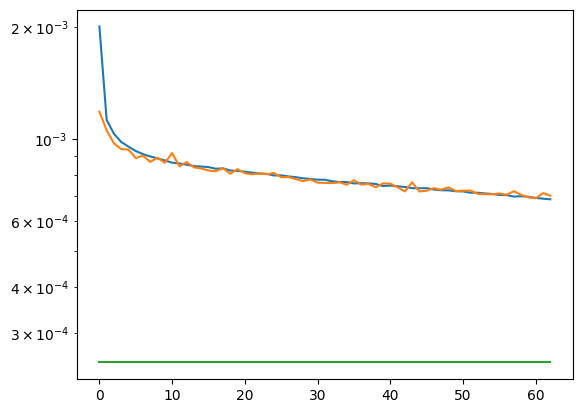

In [76]:
import matplotlib.pyplot as plt
plt.semilogy(epoch_loss_train)
plt.semilogy(epoch_loss_val)
plt.semilogy(lr_list)
print(epoch_loss_train[-1],epoch_loss_val[-1])

In [77]:
# torch.save(model.state_dict(),"model_general")
# model.load_state_dict(torch.load("model_general"))
# model = model.to(device)

In [31]:
train_loader = DataLoader(list(zip(train_combined,train_inputs_global)), batch_size=1, shuffle=False)
df_result_train = list()
k=0
with torch.no_grad():

    for batch,inputs_global in train_loader:

        print("Particle number : ",str(k+1))
        batch.to(device) 
        inputs_global = inputs_global.float().cuda() 

        # Passing the node features and the connection info
        pred = model( batch.x.float() , batch.edge_index, inputs_global, batch.batch)
        df_result_train.append(np.array([batch.y.detach().cpu().numpy()[0][0],pred.detach().cpu().numpy()[0][0]]))    
        clear_output(wait=True)
        k=k+1

        if k==1000:
            break
         
# train_results_pd = pd.DataFrame( np.concatenate( (all_tags[train_indices],np.array(df_result_train)),axis=1 ) ,columns = ["AR","Phi","Re","GT Drag","Pred Drag"])

Particle number :  1000


0.5936526839574614


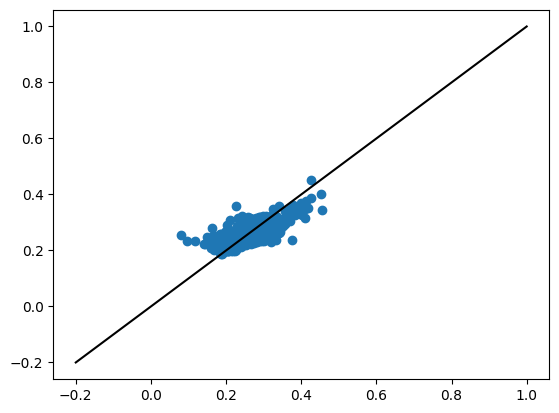

In [32]:
plt.scatter( np.array(df_result_train)[:,0],np.array(df_result_train)[:,1] )
print(r2_score(np.array(df_result_train)[:,0],np.array(df_result_train)[:,1]))
plt.plot( np.linspace(-0.2,1,10) , np.linspace(-0.2,1,10),c='black')

In [78]:
test_loader = DataLoader(list(zip(test_combined,test_inputs_global)), batch_size=1, shuffle=False)
df_result_test = list()
k=0
with torch.no_grad():

    for batch,inputs_global in test_loader:

        print("Particle number : ",str(k+1))
        batch.to(device) 
        inputs_global = inputs_global.float().cuda() 

        # Passing the node features and the connection info
        pred = model( batch.x.float() , batch.edge_index, inputs_global, batch.batch)
        df_result_test.append(np.array([batch.y.detach().cpu().numpy()[0][0],pred.detach().cpu().numpy()[0][0]]))    
        clear_output(wait=True)
        k=k+1

        # if k==1000:
        #     break
 
# test_results_pd = pd.DataFrame( np.concatenate( (all_tags[test_indices],np.array(df_result_test)),axis=1 ) ,columns = ["AR","Phi","Re","GT Drag","Pred Drag"])

Particle number :  9015


0.7275989025921605


Text(0, 0.5, 'Predictions')

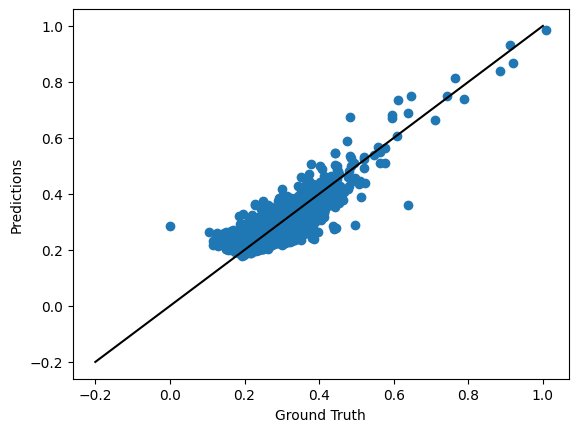

In [79]:
plt.scatter( np.array(df_result_test)[:,0],np.array(df_result_test)[:,1] )
print(r2_score(np.array(df_result_test)[:,0],np.array(df_result_test)[:,1]))
plt.plot( np.linspace(-0.2,1,10) , np.linspace(-0.2,1,10),c='black')
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")

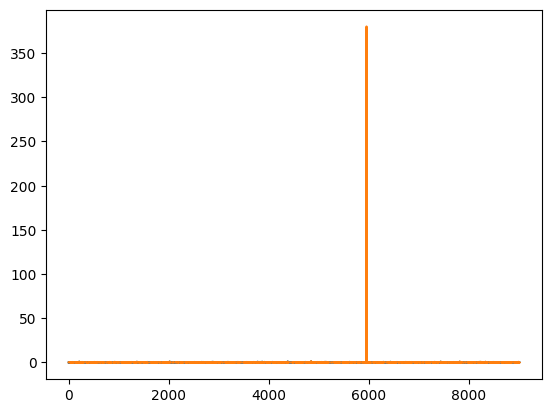

In [87]:
plt.plot(from_mean)
plt.plot(from_pred)

Text(0, 0.5, 'Percentage of total')

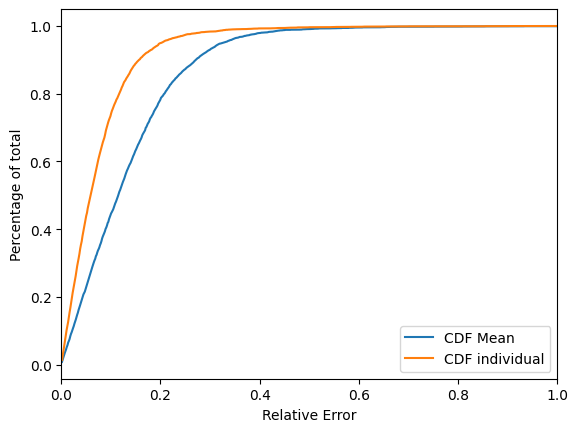

In [90]:
from_mean = np.abs( (np.array(df_result_test)[:,0][0:5000] - np.array(df_result_test)[:,0][0:5000].mean())/np.array(df_result_test)[:,0][0:5000] )
from_pred = np.abs( (np.array(df_result_test)[:,0][0:5000] - np.array(df_result_test)[:,1][0:5000])/np.array(df_result_test)[:,0][0:5000] )

count, bins_count_mean = np.histogram(from_mean, bins=1000)
pdf = count / sum(count) 
cdf_mean = np.cumsum(pdf) 

count, bins_count = np.histogram(from_pred, bins=1000)
pdf = count / sum(count) 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count_mean[1:], cdf_mean, label="CDF Mean")
plt.plot(bins_count[1:], cdf, label="CDF individual")
plt.legend() 

plt.xlim([0,1])
plt.xlabel("Relative Error")
plt.ylabel("Percentage of total")

In [ ]:
plt.scatter(train_results_pd["GT Drag"],train_results_pd["Pred Drag"],c="blue",edgecolor='black')
# plt.scatter(test_results_pd["GT Drag"],test_results_pd["Pred Drag"],c="red",edgecolor='black')
plt.plot( np.linspace(-0.2,train_results_pd["GT Drag"].values.max(),10) , np.linspace(-0.2,train_results_pd["GT Drag"].values.max(),10),c='black')
print("R_2 = ",str(r2_score(train_results_pd["GT Drag"].values,train_results_pd["Pred Drag"].values)) )

In [132]:
import pandas as pd

# Example DataFrame with three levels of multi-index
arrays = [['A', 'A', 'B', 'B'], [1, 1, 2, 2], ['X', 'Y', 'X', 'Y']]
index = pd.MultiIndex.from_arrays(arrays, names=('first', 'second', 'third'))
df = pd.DataFrame({'value': [10, 20, 30, 40]}, index=index)

# Access values based on column values of each series
value_A1_X = df.loc[('A', 1, 'X'), 'value']
value_B2_Y = df.loc[('B', 2, 'Y'), 'value']

print("Value for ('A', 1, 'X') in 'value' column:", value_A1_X)
print("Value for ('B', 2, 'Y') in 'value' column:", value_B2_Y)


Value for ('A', 1, 'X') in 'value' column: 10
Value for ('B', 2, 'Y') in 'value' column: 40


<Axes: ylabel='Density'>

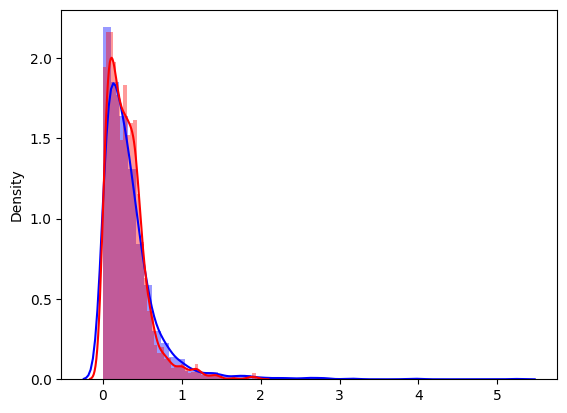

In [133]:
### Experiment-wise analysis ###

### Getting mean drag per experiment and adding as column ###
mean_drags_pd = pd.DataFrame(np.concatenate((all_tags,all_data_pd_scaled[:,-1][:,None]),axis=1),columns=["AR","Phi","Re","GT Drag"])
mean_drags_pd = mean_drags_pd.groupby(["AR","Phi","Re"]).mean()
mean_drag_list = [temp.loc[(test_results_pd["AR"].values[i], test_results_pd["Phi"].values[i],test_results_pd["Re"].values[i]), 'GT Drag'] for i in range(len(test_results_pd))] 
test_results_pd["Mean GT Drag"] = mean_drag_list

### Defining Relative error ###

### Train ###
train_results_pd["Rel Err"] = np.abs(train_results_pd["GT Drag"].values - train_results_pd["Pred Drag"].values)/train_results_pd["GT Drag"].values 

### Test ###
test_results_pd["Rel Err"] = np.abs(test_results_pd["GT Drag"].values - test_results_pd["Pred Drag"].values)/test_results_pd["GT Drag"].values  
test_results_pd["Rel Err From Mean Drag"] = np.abs(test_results_pd["GT Drag"].values - test_results_pd["Mean GT Drag"].values)/test_results_pd["GT Drag"].values

sns.distplot(test_results_pd["Rel Err"].values,color="blue")
sns.distplot(test_results_pd["Rel Err From Mean Drag"].values,color="red")

In [129]:
test_results_pd.groupby(["AR","Phi","Re"]).mean()

GT Drag  Pred Drag   Rel Err  Mean GT Drag  \
AR   Phi  Re                                                   
2.5  0.10 10.0   0.019021  -0.005705  1.505399      0.015448   
          50.0   0.042401   0.021717  0.622380      0.038799   
          100.0  0.066937   0.048259  0.473201      0.063039   
          200.0  0.115263   0.092998  0.437356      0.110101   
     0.20 10.0   0.064455   0.033494  0.525353      0.052749   
          50.0   0.108720   0.075772  0.353493      0.091376   
          100.0  0.153539   0.119884  0.292101      0.131786   
          200.0  0.238830   0.209167  0.270490      0.210565   
     0.30 10.0   0.120253   0.113529  0.302288      0.099946   
          50.0   0.196382   0.176298  0.246760      0.163231   
          100.0  0.267513   0.240169  0.230475      0.224578   
          200.0  0.409114   0.364491  0.250611      0.344483   
5.0  0.10 10.0   0.035306   0.021034  0.793027      0.028484   
          50.0   0.070936   0.055340  0.417297      0.062010   
          100.0  0.107532   0.091385  0.369824      0.096876   
          200.0  0.177956   0.159063  0.333899      0.163644   
     0.20 10.0   0.071533   0.074800  0.318676      0.073321   
          50.0   0.126710   0.128119  0.265115      0.130368   
          100.0  0.182511   0.184922  0.246043      0.187766   
          200.0  0.287079   0.292589  0.244125      0.296288   
     0.30 10.0   0.174642   0.160641  0.294941      0.161813   
          50.0   0.251804   0.230866  0.281489      0.240062   
          100.0  0.327431   0.305592  0.268391      0.319742   
          200.0  0.471421   0.449105  0.266764      0.473398   
10.0 0.10 10.0   0.072746   0.078340  0.452327      0.050259   
          50.0   0.138714   0.126023  0.318592      0.101436   
          100.0  0.204150   0.178261  0.291384      0.152438   
          200.0  0.322421   0.282624  0.270236      0.244479   
     0.15 10.0   0.088943   0.097380  0.276169      0.078055   
          50.0   0.150078   0.151637  0.234714      0.136362   
          100.0  0.210570   0.206414  0.231961      0.195419   
          200.0  0.321559   0.308958  0.241104      0.304739   
     0.20 10.0   0.133632   0.134577  0.299362      0.121167   
          50.0   0.212542   0.198293  0.277068      0.195012   
          100.0  0.290667   0.266723  0.263843      0.268441   
          200.0  0.435140   0.394973  0.282890      0.402438   

                 Rel Err From Mean Drag  
AR   Phi  Re                             
2.5  0.10 10.0                 0.434082  
          50.0                 0.356213  
          100.0                0.363503  
          200.0                0.383278  
     0.20 10.0                 0.274309  
          50.0                 0.263985  
          100.0                0.260762  
          200.0                0.280935  
     0.30 10.0                 0.259072  
          50.0                 0.253422  
          100.0                0.249670  
          200.0                0.271550  
5.0  0.10 10.0                 0.380496  
          50.0                 0.344399  
          100.0                0.364050  
          200.0                0.413430  
     0.20 10.0                 0.286398  
          50.0                 0.283149  
          100.0                0.277082  
          200.0                0.297325  
     0.30 10.0                 0.236202  
          50.0                 0.249477  
          100.0                0.261739  
          200.0                0.294295  
10.0 0.10 10.0                 0.320252  
          50.0                 0.334596  
          100.0                0.347974  
          200.0                0.379798  
     0.15 10.0                 0.197356  
          50.0                 0.214647  
          100.0                0.231505  
          200.0                0.255580  
     0.20 10.0                 0.285252  
          50.0                 0.326873  
          100.0                0.349249  
          200.0                

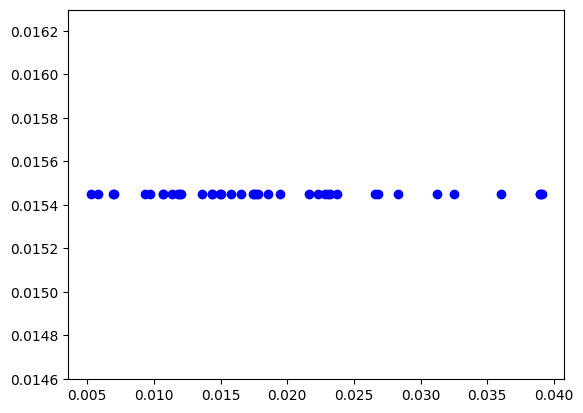

In [140]:
subset = test_results_pd[(test_results_pd["AR"]==2.5)&(test_results_pd["Phi"]==0.1)&(test_results_pd["Re"]==10)]
# plt.scatter(subset["GT Drag"],subset["Pred Drag"],c="b")
plt.scatter(subset["GT Drag"],subset["Mean GT Drag"],c="b")

(-0.05, 1.0)

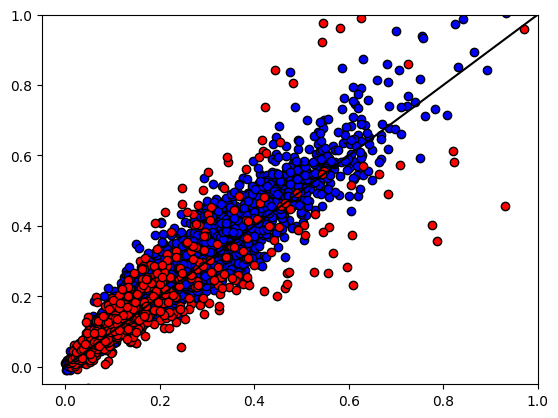

In [42]:
plt.scatter(df_result_train["GT"],df_result_train["Pred"],c="blue",edgecolor='black')
plt.scatter(df_result_test["GT"],df_result_test["Pred"],c="red",edgecolor='black')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),c='black')
plt.ylim([-0.05,1])
plt.xlim([-0.05,1])

In [62]:
all_tags = np.load("ze_tags_2p5.npy")
all_tags_test = all_tags[test_indices]
final_result = np.concatenate((df_result_test["GT"].values[:,None],df_result_test["Pred"].values[:,None],all_tags_test[:,2:]),axis=1)
final_result = pd.DataFrame(final_result,columns=["GT","Pred","Phi","Re"])
final_result["rel_err"] = np.abs(final_result["GT"].values-final_result["Pred"].values)/final_result["GT"].values
final_result.groupby(["Phi","Re"]).mean()

### Compare with the mean predictions ###

GT      Pred   rel_err
Phi Re                                 
0.1 10.0   0.025390  0.023404  0.685647
    50.0   0.057130  0.054533  0.536844
    100.0  0.090440  0.089012  0.469745
    200.0  0.156047  0.162440  0.438461
0.2 10.0   0.087071  0.082069  0.273151
    50.0   0.147164  0.141268  0.291524
    100.0  0.208011  0.200884  0.299310
    200.0  0.323801  0.311374  0.336716
0.3 10.0   0.162822  0.185535  0.334507
    50.0   0.266174  0.276285  0.321340
    100.0  0.362741  0.381657  0.355408
    200.0  0.554979  0.579634  0.361682

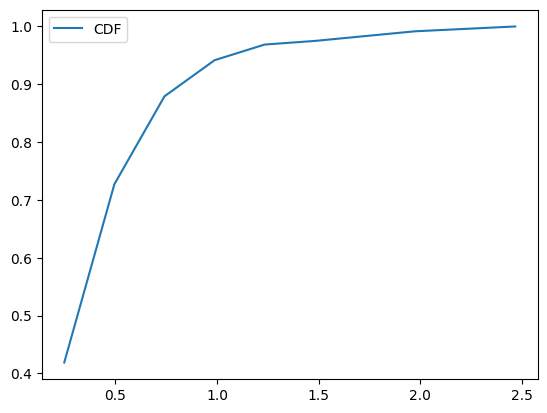

In [63]:
count, bins_count = np.histogram(final_result["rel_err"].values, bins=10) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
# plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend() 

In [ ]:
# attributes = list()
# ### add re column to the data list 
# for i in range(len(data)):
#     indices = list()
#     print("Particle number : ",str(i+1))
#     for value in data[i][0][:,1]:    
#         # Get the row indices where column 'A' has the specified value
#         indices.append( df.index[df['Center_x'] == value].tolist() )
#         attributes.append(df.iloc[indices[0]][["Re","Inclination_angle","Drag_local"]])
#         break
#     break
#     clear_output(wait=True)
    
# ### Concatenating the attrivutes with the data array ###
# # data_with_attributes = [np.concatenate((data[i][0],attributes[i].values),axis=1) for i in range(len(data))]

In [ ]:
### Checking ###
# train_indices = np.arange(2000).astype(int)
# train = [all_dat[train_indices[i]].x for i in range(len(train_indices))]
# train_np = np.vstack(train)

# max_vals = np.max(train_np,axis=0)
# min_vals = np.min(train_np,axis=0)

# train_np_scaled = np.array(train_np - min_vals)/(max_vals-min_vals)
# train_np_scaled.shape

In [ ]:
# ### Rough code to verify conncections ###
# center_shifted = particle_shift(center_10,shift=10)
# points_ref = np.array(center_shifted[["x","y","z"]])
# tree = cKDTree(points_ref)

# ### Choosing a POI on random ###
# n_random = np.random.randint(len(center_10))
# random_poi = np.array(center_10.iloc[n_random][["x","y","z"]])
# print("Particle of interest location and index : ", random_poi, n_random,'\n')

# first_deg = points_ref[tree.query(random_poi,5)[1]]
# points_ref_remaining = array_difference(points_ref,first_deg)

# print("First Deg neighbors \n",first_deg,'\n')
# tree = cKDTree(points_ref_remaining)
# second_deg = points_ref_remaining[tree.query( first_deg[4,:] , 5 )[1]]

# print("Second Deg neighbors \n",second_deg)
# # get_nearest_quick(all_points = points_ref, points_to_exclude  = np.array([]), n_nearest = 1)

In [ ]:
### Rough code to verify scaling ###
# drag_forces = df[ (df["Center_x"]>7.5) & (df["Center_x"]<17.5)]["Drag_local"].values
# train_drags = np.array(drag_forces[train_indices])
# test_drags = np.array(drag_forces[test_indices])
# max_drag,min_drag = train_drags.max(),train_drags.min()

# train_drags = np.array( (train_drags-min_drag)/(max_drag-min_drag))
# test_drags = np.array( (test_drags-min_drag)/(max_drag-min_drag))
# drags_scaled = np.concatenate((train_drags,test_drags))

In [ ]:
# len(data_with_attributes)
# # sf_200 = 
# df_reduced = df[(df["Center_x"]>7.5)&(df["Center_x"]<17.5)]

# drags = df_reduced[(df_reduced["phi"]==10)&(df_reduced["Re"]==200)]["Drag_local"].values
# print(drags.max()-drags.min(),np.var(drags))

# drags = df_reduced[(df_reduced["phi"]==20)&(df_reduced["Re"]==200)]["Drag_local"].values
# print(drags.max()-drags.min(),np.var(drags))

# drags = df_reduced[(df_reduced["phi"]==30)&(df_reduced["Re"]==200)]["Drag_local"].values
# print(drags.max()-drags.min(),np.var(drags))

In [ ]:
# from torch_geometric.data import DataLoader
# import warnings
# warnings.filterwarnings("ignore")

# # Root mean squared error
# loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)  

# # Use GPU for training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Wrap data in a data loader
# data_size = len(data)
# NUM_GRAPHS_PER_BATCH = 16

# loader = DataLoader(train_combined, 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

# test_loader = DataLoader(test_combined, 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

# def train():
#     # Enumerate over the data
#     batch_loss = list()
#     for batch in loader:
#       # Use GPU
#       batch.to(device) 
      
#       # Reset gradients
#       optimizer.zero_grad() 
      
#       # Passing the node features and the connection info
#       pred = model(batch.x.float(), batch.edge_index, batch.batch)
      
#       # Calculating the loss and gradients
#       loss = loss_fn(pred, batch.y)
#       batch_loss.append(loss.item())
#       loss.backward()  
        
#       # Update using the gradients
#       optimizer.step()   
        
#     return np.mean(batch_loss)


# def validate():
#     # Enumerate over the data
    
#     batch_loss = list()
    
#     for batch in test_loader:
      
#       # Use GPU
#       batch.to(device) 

#       # Passing the node features and the connection info
#       pred = model( batch.x.float() , batch.edge_index, batch.batch)
      
#       # Calculating the loss and gradients
#       loss = loss_fn(pred, batch.y) 
#       batch_loss.append(loss.item())
         
#     return np.mean(batch_loss)

# print("Starting training...")
# losses = []
# losses_val = []

# ### Load Checkpoint ###
# # model.load_state_dict(torch.load("model_general"))
# # model = model.to(device)

# for epoch in range(20):
    
#     ### Train ###
#     loss = train()
#     losses.append(loss)

#     ### Val ###
#     loss_val = validate()
#     losses_val.append(loss_val)
    
#     if epoch % 1 == 0:
#       print(f"Epoch {epoch} | Train Loss {losses[-1]}")
#       print(f"Val Loss {losses_val[-1]}")
#       print('\n')
    
# # losses = torch.stack(losses).detach().cpu().numpy()

In [ ]:
# ### Generate dataset corrected ###

# ### Sf=0.1 ###
# ### Generating the n nearest neighbors ###
# tree = cKDTree(center_shifted_10.values)
# idx = np.stack([tree.query(center_10_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_10_dev))])
# input_dat_sf10 = np.stack([center_shifted_10.iloc[idx[i]] for i in range(len(idx))])
# input_dat_sf10 = input_dat_sf10.reshape(input_dat_sf10.shape[0],input_dat_sf10.shape[1]*input_dat_sf10.shape[2])

# ### Adding solid fraction column ###
# input_dat_sf10 = add_const_parameter(input_dat_sf10,0.1)

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat_sf10 = np.vstack( ( add_const_parameter(input_dat_sf10,10),
#                    add_const_parameter(input_dat_sf10,50),
#                    add_const_parameter(input_dat_sf10,100),
#                    add_const_parameter(input_dat_sf10,200),
#                     ) )

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# join_additions = list()
# for i in range(len(input_dat_sf10)):
#     idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf10[i][[0,1,2,-1]]).all(axis=1) )
#     join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
# input_dat_sf10 = np.hstack((input_dat_sf10,np.stack(join_additions)))


# ### Sf=0.2 ###
# ### Generating the n nearest neighbors ###
# tree = cKDTree(center_shifted_20.values)
# idx = np.stack([tree.query(center_20_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_20_dev))])
# input_dat_sf20 = np.stack([center_shifted_20.iloc[idx[i]] for i in range(len(idx))])
# input_dat_sf20 = input_dat_sf20.reshape(input_dat_sf20.shape[0],input_dat_sf20.shape[1]*input_dat_sf20.shape[2])

# ### Adding solid fraction column ###
# input_dat_sf20 = add_const_parameter(input_dat_sf20,0.2)

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat_sf20 = np.vstack( ( add_const_parameter(input_dat_sf20,10),
#                    add_const_parameter(input_dat_sf20,50),
#                    add_const_parameter(input_dat_sf20,100),
#                    add_const_parameter(input_dat_sf20,200),
#                     ) )

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# join_additions = list()
# for i in range(len(input_dat_sf20)):
#     idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf20[i][[0,1,2,-1]]).all(axis=1) )
#     join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
# input_dat_sf20 = np.hstack((input_dat_sf20,np.stack(join_additions)))


# ### Sf=0.3 ###
# ### Generating the n nearest neighbors ###
# tree = cKDTree(center_shifted_30.values)
# idx = np.stack([tree.query(center_30_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_30_dev))])
# input_dat_sf30 = np.stack([center_shifted_30.iloc[idx[i]] for i in range(len(idx))])
# input_dat_sf30 = input_dat_sf30.reshape(input_dat_sf30.shape[0],input_dat_sf30.shape[1]*input_dat_sf30.shape[2])

# ### Adding solid fraction column ###
# input_dat_sf30 = add_const_parameter(input_dat_sf30,0.3)

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat_sf30 = np.vstack( ( add_const_parameter(input_dat_sf30,10),
#                    add_const_parameter(input_dat_sf30,50),
#                    add_const_parameter(input_dat_sf30,100),
#                    add_const_parameter(input_dat_sf30,200),
#                     ) )

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# join_additions = list()
# for i in range(len(input_dat_sf30)):
#     idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf30[i][[0,1,2,-1]]).all(axis=1) )
#     join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
# input_dat_sf30 = np.hstack((input_dat_sf30,np.stack(join_additions)))

# ### Combining all three solid fractions ###
# all_data = np.vstack((input_dat_sf10,input_dat_sf20,input_dat_sf30))

# ### Converting to DataFrame and renaming the columns ###
# all_data_pd = pd.DataFrame(all_data,columns=["POI_x","POI_y","POI_y",
#                                              "neigh_1_x","neigh_1_y","neigh_1_z",
#                                              "neigh_2_x","neigh_2_y","neigh_2_z",
#                                              "neigh_3_x","neigh_3_y","neigh_3_z",
#                                              "neigh_4_x","neigh_4_y","neigh_4_z",
#                                              "neigh_5_x","neigh_5_y","neigh_5_z",
#                                              "neigh_6_x","neigh_6_y","neigh_6_z",
#                                              "neigh_7_x","neigh_7_y","neigh_7_z",
#                                              "neigh_8_x","neigh_8_y","neigh_8_z",
#                                              "neigh_9_x","neigh_9_y","neigh_9_z",
#                                              "neigh_10_x","neigh_10_y","neigh_10_z",
#                                              "neigh_11_x","neigh_11_y","neigh_11_z",
#                                              "neigh_12_x","neigh_12_y","neigh_12_z",
#                                              "neigh_13_x","neigh_13_y","neigh_13_z",
#                                              "neigh_14_x","neigh_14_y","neigh_14_z",
#                                              "neigh_15_x","neigh_15_y","neigh_16_z",
#                                               "Re","Phi","Inclination_angle","Drag_local"])
# all_data_pd

In [ ]:
# import torch
# from torch.nn import Linear
# import torch.nn.functional as F 
# from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
# from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

# gnn_layer_by_name = {
#     "GCN": geom_nn.GCNConv,
#     "GAT": geom_nn.GATConv,
#     "GraphConv": geom_nn.GraphConv
# }

# class GNNModel(nn.Module):

#     def __init__(self, c_in, c_hidden, c_out, num_layers=3, layer_name="GCN", dp_rate=0.05, **kwargs):
        
#         """
#         Inputs:
#             c_in - Dimension of input features
#             c_hidden - Dimension of hidden features
#             c_out - Dimension of the output features. Usually number of classes in classification
#             num_layers - Number of "hidden" graph layers
#             layer_name - String of the graph layer to use
#             dp_rate - Dropout rate to apply throughout the network
#             kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
#         """
        
#         super().__init__()
#         gnn_layer = gnn_layer_by_name[layer_name]

#         layers = []
#         in_channels, out_channels = c_in, c_hidden
        
#         for l_idx in range(num_layers-1):
#             layers += [
#                 gnn_layer(in_channels=in_channels,
#                           out_channels=out_channels,
#                           **kwargs),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(dp_rate)
#             ]
#             in_channels = c_hidden
            
#         layers += [gnn_layer(in_channels=in_channels,
#                              out_channels=c_out,
#                              **kwargs)]
#         self.layers = nn.ModuleList(layers)

#     def forward(self, x, edge_index):
#         """
#         Inputs:
#             x - Input features per node
#             edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
#         """
#         for l in self.layers:
#             # For graph layers, we need to add the "edge_index" tensor as additional input
#             # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
#             # we can simply check the class type.
            
#             if isinstance(l, geom_nn.MessagePassing):
                
#                 x = l(x, edge_index)
#                 # print("Message Passing",type(l))
#                 ### Doubt here there is message passing sometimes and not other times ###
            
#             else:
#                 x = l(x)
#                 # print("Not message passing",type(l))
#         return x

In [ ]:
# class GraphGNNModel(nn.Module):

#     def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.05, **kwargs):
#         """
#         Inputs:
#             c_in - Dimension of input features
#             c_hidden - Dimension of hidden features
#             c_out - Dimension of output features (usually number of classes)
#             dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
#             kwargs - Additional arguments for the GNNModel object
#         """
#         super().__init__()
#         self.GNN = GNNModel(c_in=c_in,
#                             c_hidden=c_hidden,
#                             c_out=c_hidden, # Not our prediction output yet!
#                             **kwargs)
#         self.head = nn.Sequential(
#             nn.Dropout(dp_rate_linear),
#             nn.Linear(c_hidden*2, 1)
#         )

#     def forward(self, x, edge_index, batch_idx):
#         """
#         Inputs:
#             x - Input features per node
#             edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
#             batch_idx - Index of batch element for each node
#         """
#         x = self.GNN(x, edge_index)
#         # x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
#         x = torch.cat([gmp(x, batch_idx), 
#                             gap(x, batch_idx)], dim=1)
#         x = self.head(x)
        
#         return x

# model = GraphGNNModel(c_in=6, c_hidden=164, c_out=128).cuda()
# print(model)
# print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [ ]:
### Define Train Indices and perform scaling ###
# check_points = np.array([0,center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],
#           center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],
#          center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0]]).cumsum() 

# test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
# train_indices = np.setdiff1d( np.arange(len(all_data_graph_struct)) , test_indices )
# train_combined,test_combined = min_max_scaler(all_data_graph_struct,train_indices)

### Box scaling ###
### Split to train and test ###
# train_combined,test_combined = [ all_data_graph_struct[train_indices[i]] for i in range(len(train_indices)) ],[ all_data_graph_struct[test_indices[i]] for i in range(len(test_indices))]

# ### Covert to pandas Dataframes ###
# for i in range(len(train_combined)):
    
#     train_combined[i].x = pd.DataFrame(train_combined[i].x,columns=["x","y","z","phi","Re","Inclination_angle"])
#     train_combined[i].x = torch.tensor(box_scale(train_combined[i].x).values)
    
#     train_combined[i].y = pd.DataFrame(train_combined[i].y,columns=["Drag_local"])
#     train_combined[i].y = torch.tensor(box_scale(train_combined[i].y).values)
    
# for i in range(len(test_combined)):
    
#     test_combined[i].x = pd.DataFrame(test_combined[i].x,columns=["x","y","z","phi","Re","Inclination_angle"])
#     test_combined[i].x = torch.tensor(box_scale(test_combined[i].x).values)
    
#     test_combined[i].y = pd.DataFrame(test_combined[i].y,columns=["Drag_local"])
#     test_combined[i].y = torch.tensor(box_scale(test_combined[i].y).values)